### Acousticbrainz classifier patterns
Notebook **acousticbrainz_stability** showed that a many of the classifiers are relatively unstable, and that correlation between classifiers modeling the same concept is not as high as would be expected. Those correlation plots showed interesting patterns, which will be further explored here.

In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(15, 15)})

from tqdm.notebook import tqdm
tqdm().pandas()


# Load in the acousticbrainz dataset into the variable 'acousticbrainz'
acousticbrainz = pd.read_hdf(Path.cwd() / 'datasets' / 'acousticbrainzV3.h5')

acousticbrainz['mbid'] = acousticbrainz.index.get_level_values(0)

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


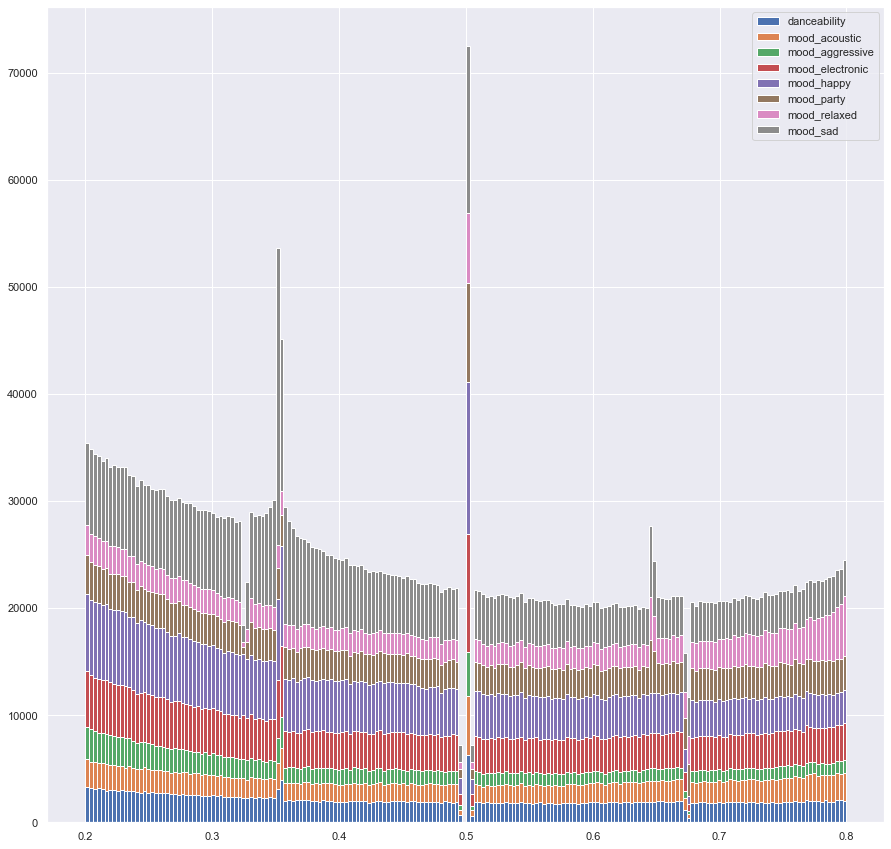

In [2]:
# List of columns to inspect, binary 'mood' features. Positive class is always chosen
toSelect = [('danceability', 'danceable'), ('mood_acoustic', 'acoustic'),
       ('mood_aggressive', 'aggressive'), ('mood_electronic', 'electronic'),
       ('mood_happy', 'happy'), ('mood_party', 'party'),
       ('mood_relaxed', 'relaxed'), ('mood_sad', 'sad')]


fig = plt.figure()
ax = fig.gca()

cols = [acousticbrainz[x] for x in toSelect]
filtered = [col[(col > 0.2) & (col < 0.8)] for col in cols]
labels = [x[0] for x in toSelect]

ax.hist(filtered, bins=200, stacked=True, label=labels)
ax.legend()

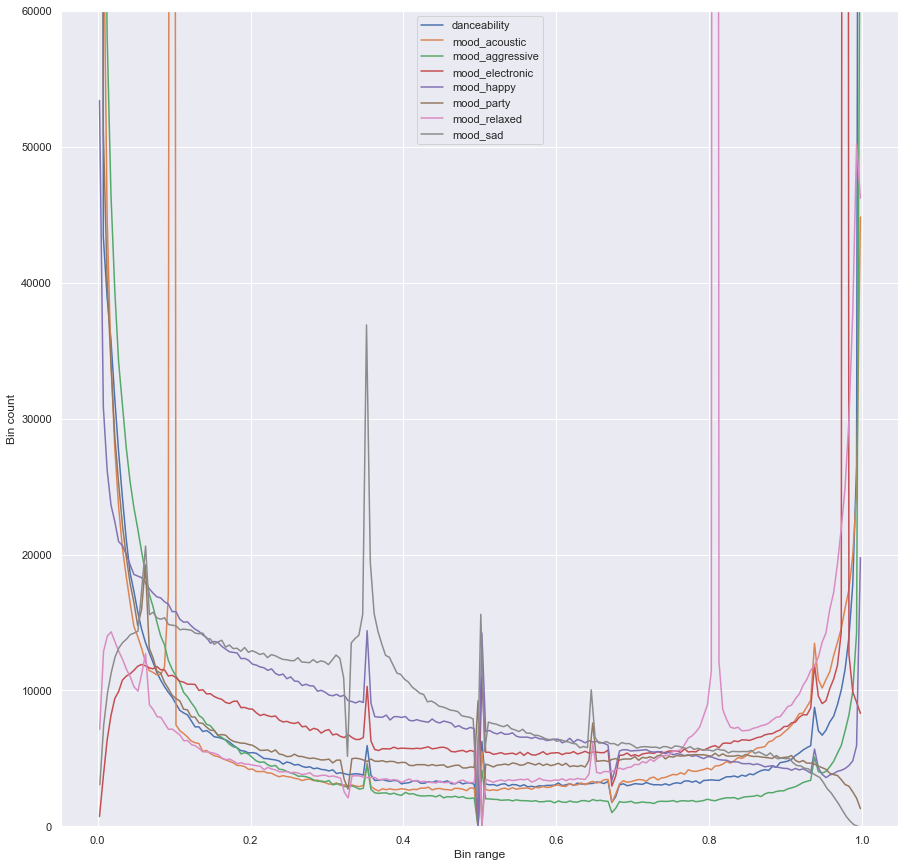

In [3]:
fig = plt.figure()
plt.ylim(top=60000)
plt.xlabel('Bin range')
plt.ylabel('Bin count')

for i in range(0, len(cols)):
    y,binEdges = np.histogram(cols[i],bins=200)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters, y, label=labels[i])

plt.legend()
plt.show()
    

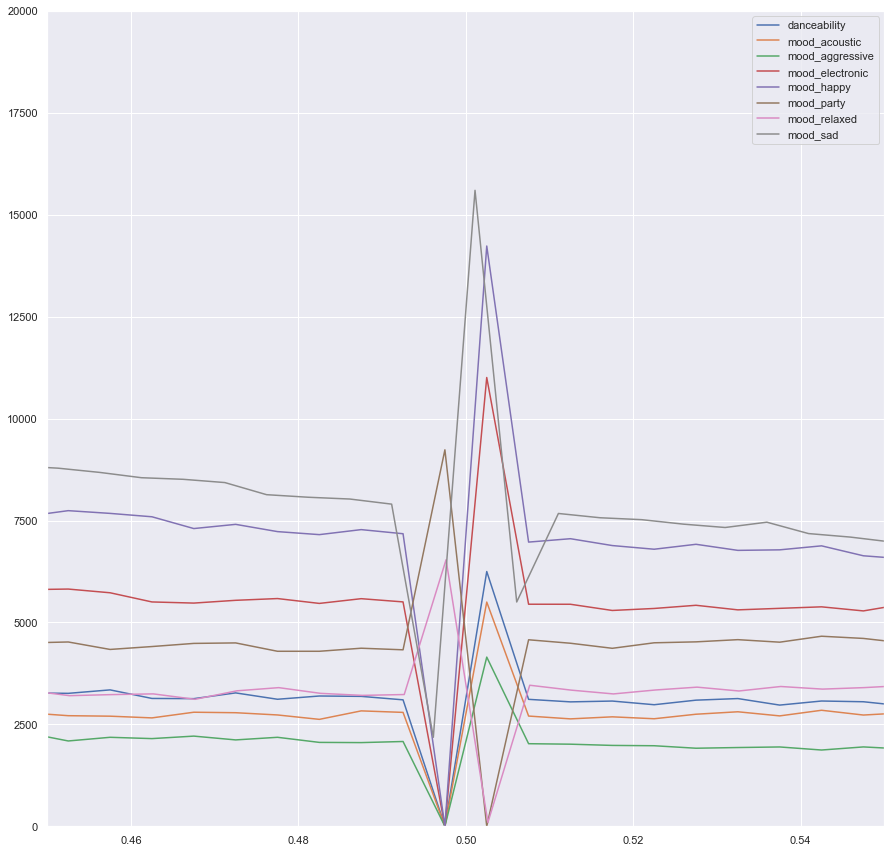

In [4]:
fig = plt.figure()
plt.xlim(0.45, 0.55)
plt.ylim(top=20000)

for i in range(0, len(cols)):
    y,binEdges = np.histogram(cols[i],bins=200)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    plt.plot(bincenters, y, label=labels[i])

plt.legend()
plt.show()

Now, we wish to investigate these spikes and dips a bit more, first we consider that metadata like bitrate or the essentia version used to extract might explain these peaks:

In [5]:
# Spike in acousticness at 0.09 - 0.10
acoust_spike = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.09, 0.10, inclusive=True)]

# Spike in mood relaxed at 0.805 - 0.815
relaxed_spike = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.805, 0.815, inclusive=True)]

# Spike in mood electronic at 0.972 - 0.982
electronic_spike = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.972, 0.982, inclusive=True)]

# Small spike in sad, party, electronic, danceability, acoustic, aggressive at 0.346 - 0.362
combined_spike = acousticbrainz[acousticbrainz[('mood_sad', 'sad')].between(0.346, 0.362, inclusive=True)]

# Small dip in sad, party, relaxed at 0.317 - 0.3317
combined_dip = acousticbrainz[acousticbrainz[('mood_sad', 'sad')].between(0.317, 0.3317, inclusive=True)]


# Check if any pattern in the amount of lossless songs:
loss_full = acousticbrainz['lossless'].value_counts(normalize=True)
loss_acoust_spike = acoust_spike['lossless'].value_counts(normalize=True)
loss_relaxed_spike = relaxed_spike['lossless'].value_counts(normalize=True)
loss_electronic_spike = electronic_spike['lossless'].value_counts(normalize=True)
loss_combined_spike = combined_spike['lossless'].value_counts(normalize=True)
loss_combined_dip = combined_dip['lossless'].value_counts(normalize=True)

lossless_stats = pd.DataFrame([loss_full[1], loss_acoust_spike[1], loss_relaxed_spike[1],
                               loss_electronic_spike[1], loss_combined_spike[1], loss_combined_dip[1]],
            index=['Full', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Combined spike', 'Combined dip'],
            columns = ['Percentage lossless'])

display(lossless_stats)
print(lossless_stats.to_latex())

# Check if any pattern in the codec of the songs:
codec_full = acousticbrainz['codec'].value_counts(normalize=True)
codec_acoust_spike = acoust_spike['codec'].value_counts(normalize=True)
codec_relaxed_spike = relaxed_spike['codec'].value_counts(normalize=True)
codec_electronic_spike = electronic_spike['codec'].value_counts(normalize=True)
codec_combined_spike = combined_spike['codec'].value_counts(normalize=True)
codec_combined_dip = combined_dip['codec'].value_counts(normalize=True)

codec_stats = pd.DataFrame([codec_full, codec_acoust_spike, codec_relaxed_spike,
                               codec_electronic_spike, codec_combined_spike, codec_combined_dip],
            index=['Full', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Combined spike', 'Combined dip'],)

display(codec_stats)
print(codec_stats[['mp3', 'flac', 'vorbis', 'aac', 'alac']].fillna(value=0.0).to_latex())

# Most versions are the same, however the essentia version for the low level features
# (used to calculate the high level features) does have some variation
ver_full = acousticbrainz['essentia_low'].value_counts(normalize=True)
ver_acoust_spike = acoust_spike['essentia_low'].value_counts(normalize=True)
ver_relaxed_spike = relaxed_spike['essentia_low'].value_counts(normalize=True)
ver_electronic_spike = electronic_spike['essentia_low'].value_counts(normalize=True)
ver_combined_spike = combined_spike['essentia_low'].value_counts(normalize=True)
ver_combined_dip = combined_dip['essentia_low'].value_counts(normalize=True)

ver_stats = pd.DataFrame([ver_full, ver_acoust_spike, ver_relaxed_spike,
                          ver_electronic_spike, ver_combined_spike, ver_combined_dip],
                        index=['Full', 'Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Combined spike', 'Combined dip'])

display(ver_stats)
print(ver_stats.to_latex())


,Percentage lossless
Full,0.325822
Acoustic spike,0.105501
Relaxed spike,0.162542
Electronic spike,0.117786
Combined spike,0.364800
Combined dip,0.297760


\begin{tabular}{lr}
\toprule
{} &  Percentage lossless \\
\midrule
Full             &             0.325822 \\
Acoustic spike   &             0.105501 \\
Relaxed spike    &             0.162542 \\
Electronic spike &             0.117786 \\
Combined spike   &             0.364800 \\
Combined dip     &             0.297760 \\
\bottomrule
\end{tabular}



,mp3,flac,vorbis,aac,alac,wmav2,mpc7,mp2,ape,wavpack,mpc8,mp1,wmapro
Full,0.598476,0.320427,0.039505,0.033874,0.005316,0.001802,0.000348,0.000096,0.000079,0.000068,0.000006,0.000001,5.537368e-07
Acoustic spike,0.844213,0.083374,0.028633,0.017084,0.022121,0.004125,0.000137,0.000089,0.000006,0.000195,0.000022,NaN,NaN
Relaxed spike,0.783913,0.144755,0.031341,0.018086,0.017748,0.003685,0.000165,0.000091,0.000039,0.000159,0.000019,NaN,NaN
Electronic spike,0.832754,0.097053,0.029009,0.016009,0.020728,0.004023,0.000110,0.000095,0.000005,0.000192,0.000022,NaN,NaN
Combined spike,0.570315,0.361550,0.032647,0.027785,0.003250,0.003686,0.000370,0.000119,NaN,0.000277,NaN,NaN,NaN
Combined dip,0.628357,0.293620,0.038604,0.033120,0.004105,0.001522,0.000602,0.000035,0.000035,NaN,NaN,NaN,NaN


\begin{tabular}{lrrrrr}
\toprule
{} &       mp3 &      flac &    vorbis &       aac &      alac \\
\midrule
Full             &  0.598476 &  0.320427 &  0.039505 &  0.033874 &  0.005316 \\
Acoustic spike   &  0.844213 &  0.083374 &  0.028633 &  0.017084 &  0.022121 \\
Relaxed spike    &  0.783913 &  0.144755 &  0.031341 &  0.018086 &  0.017748 \\
Electronic spike &  0.832754 &  0.097053 &  0.029009 &  0.016009 &  0.020728 \\
Combined spike   &  0.570315 &  0.361550 &  0.032647 &  0.027785 &  0.003250 \\
Combined dip     &  0.628357 &  0.293620 &  0.038604 &  0.033120 &  0.004105 \\
\bottomrule
\end{tabular}



,2.1-beta2,2.1-beta1
Full,0.632393,0.367607
Acoustic spike,0.112207,0.887793
Relaxed spike,0.197968,0.802032
Electronic spike,0.125277,0.874723
Combined spike,0.637921,0.362079
Combined dip,0.647075,0.352925


\begin{tabular}{lrr}
\toprule
{} &  2.1-beta2 &  2.1-beta1 \\
\midrule
Full             &   0.632393 &   0.367607 \\
Acoustic spike   &   0.112207 &   0.887793 \\
Relaxed spike    &   0.197968 &   0.802032 \\
Electronic spike &   0.125277 &   0.874723 \\
Combined spike   &   0.637921 &   0.362079 \\
Combined dip     &   0.647075 &   0.352925 \\
\bottomrule
\end{tabular}



In [6]:
# Spike in acousticness at 0.09 - 0.10
acoust_spike = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.09, 0.10, inclusive=True)]
acoust_rest_low = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.00, 0.09, inclusive=False)]
acoust_rest_high = acousticbrainz[acousticbrainz[('mood_acoustic', 'acoustic')].between(0.10, 1.00, inclusive=False)]

acoust_spike['label'] = 'anomaly'
acoust_rest_low['label'] = 'non-anomaly'
acoust_rest_high['label'] = 'non-anomaly'

acoust_anomalies = pd.concat([acoust_spike, acoust_rest_low, acoust_rest_high])
acoust_anomalies = acoust_anomalies[['codec', 'bit_rate', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'label']]
acoust_anomalies.to_csv('acousticness_anomalies.csv')

# Spike in mood relaxed at 0.805 - 0.815
relaxed_spike = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.805, 0.815, inclusive=True)]
relaxed_spike_low = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.00, 0.805, inclusive=False)]
relaxed_spike_high = acousticbrainz[acousticbrainz[('mood_relaxed', 'relaxed')].between(0.815, 1.00, inclusive=False)]

relaxed_spike['label'] = 'anomaly'
relaxed_spike_low['label'] = 'non-anomaly'
relaxed_spike_high['label'] = 'non-anomaly'

relaxed_anomalies = pd.concat([relaxed_spike, relaxed_spike_low, relaxed_spike_high])
relaxed_anomalies = relaxed_anomalies[['codec', 'bit_rate', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'label']]
relaxed_anomalies.to_csv('relaxed_anomalies.csv')

# Spike in mood electronic at 0.972 - 0.982
electronic_spike = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.972, 0.982, inclusive=True)]
electronic_spike_low = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.00, 0.972, inclusive=False)]
electronic_spike_high = acousticbrainz[acousticbrainz[('mood_electronic', 'electronic')].between(0.982, 1.00, inclusive=False)]

electronic_spike['label'] = 'anomaly'
electronic_spike_low['label'] = 'non-anomaly'
electronic_spike_high['label'] = 'non-anomaly'

electronic_anomalies = pd.concat([electronic_spike, electronic_spike_low, electronic_spike_high])
electronic_anomalies = electronic_anomalies[['codec', 'bit_rate', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low', 'label']]
electronic_anomalies.to_csv('electronic_anomalies.csv')


C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [7]:
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from scipy.spatial.distance import jensenshannon

# Spike in acousticness at 0.09 - 0.10
acoust_spike_filt = acousticbrainz[('mood_acoustic', 'acoustic')].between(0.09, 0.10, inclusive=True)

# Spike in mood relaxed at 0.805 - 0.815
relaxed_spike_filt = acousticbrainz[('mood_relaxed', 'relaxed')].between(0.805, 0.815, inclusive=True)

# Spike in mood electronic at 0.972 - 0.982
electronic_spike_filt = acousticbrainz[('mood_electronic', 'electronic')].between(0.972, 0.982, inclusive=True)

# Small spike in sad, party, electronic, danceability, acoustic, aggressive at 0.346 - 0.362
combined_spike_filt = acousticbrainz[('mood_sad', 'sad')].between(0.346, 0.362, inclusive=True)

# Small dip in sad, party, relaxed at 0.317 - 0.3317
combined_dip_filt = acousticbrainz[('mood_sad', 'sad')].between(0.317, 0.3317, inclusive=True)

# Random part for comparison sake
random_filt = acousticbrainz[('mood_sad', 'sad')].between(0.22, 0.24, inclusive=True)

filts = [acoust_spike_filt, relaxed_spike_filt, electronic_spike_filt, combined_spike_filt, combined_dip_filt, random_filt]
filtnames = ['Acoustic spike', 'Relaxed spike', 'Electronic spike', 'Combined spike', 'Combined dip', 'Random non-spike']
variables = ['analysis_sample_rate', 'bit_rate', 'codec', 'downmix', 'equal_loudness', 'length', 'lossless',
            'replay_gain', 'essentia_high', 'extractor_high', 'gaia_high', 'essentia_low', 'essentia_git_sha_low',
            'essentia_build_sha_low', 'extractor_low']
variables_sel = ['bit_rate', 'codec', 'downmix', 'lossless', 'essentia_low', 'essentia_git_sha_low', 'essentia_build_sha_low']

res = pd.DataFrame(columns=filtnames, index=variables)

def get_chi2(filt, variable):
    # 'Rest' of the distribution
    #a = acousticbrainz[variable].value_counts().to_numpy()
    a = acousticbrainz[~filt][variable].value_counts().to_numpy()
    # Part of the distribution we are interested in
    b = acousticbrainz[filt][variable].value_counts().to_numpy()
    
    c = np.array([a,b])
    
    return chi2_contingency(c)

def get_shannondist(filt, variable):
    # 'Rest' of the distribution
    #a = acousticbrainz[variable].value_counts().to_numpy()
    a = acousticbrainz[~filt][variable].value_counts()
    # Part of the distribution we are interested in
    b = acousticbrainz[filt][variable].value_counts()
    
    df = pd.DataFrame([a,b]).fillna(value=0)
    
    a = df.iloc[0].to_numpy()
    b = df.iloc[1].to_numpy()

    return jensenshannon(a, b)

for var in variables:
    print(var)
    for i in range(0, len(filts)):
        dist = get_shannondist(filts[i], var)
        res.loc[var][filtnames[i]] = dist

res

analysis_sample_rate
bit_rate
codec
downmix
equal_loudness
length
lossless
replay_gain
essentia_high
extractor_high
gaia_high
essentia_low
essentia_git_sha_low
essentia_build_sha_low
extractor_low


,Acoustic spike,Relaxed spike,Electronic spike,Combined spike,Combined dip,Random non-spike
analysis_sample_rate,0,0,0,0,0,0
bit_rate,0.433076,0.379206,0.422352,0.368154,0.383245,0.375645
codec,0.278101,0.219811,0.268022,0.0398981,0.0244351,0.0427308
downmix,0.000879808,0.000536035,0.000691021,0.00205659,0.00384933,0.000126286
equal_loudness,0,0,0,0,0,0
length,0.49297,0.474841,0.499502,0.639113,0.604048,0.515053
lossless,0.23203,0.178935,0.22239,0.0302759,0.0217572,0.0378995
replay_gain,0.809123,0.803875,0.807554,0.822327,0.827479,0.825008
essentia_high,0,0,0,0,0,0
extractor_high,0,0,0,0,0,0


In [8]:
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

display(res.style.apply(highlight_max))
print(res.to_latex())

for col in filtnames[0:-1]:
    res[col] = abs(res[col] - res['Random non-spike'])
    
display(res.style.apply(highlight_max))
print(res.to_latex())

,Acoustic spike,Relaxed spike,Electronic spike,Combined spike,Combined dip,Random non-spike
analysis_sample_rate,0,0,0,0,0,0
bit_rate,0.433076,0.379206,0.422352,0.368154,0.383245,0.375645
codec,0.278101,0.219811,0.268022,0.0398981,0.0244351,0.0427308
downmix,0.000879808,0.000536035,0.000691021,0.00205659,0.00384933,0.000126286
equal_loudness,0,0,0,0,0,0
length,0.49297,0.474841,0.499502,0.639113,0.604048,0.515053
lossless,0.23203,0.178935,0.22239,0.0302759,0.0217572,0.0378995
replay_gain,0.809123,0.803875,0.807554,0.822327,0.827479,0.825008
essentia_high,0,0,0,0,0,0
extractor_high,0,0,0,0,0,0


\begin{tabular}{lllllll}
\toprule
{} & Acoustic spike & Relaxed spike & Electronic spike & Combined spike & Combined dip & Random non-spike \\
\midrule
analysis\_sample\_rate   &              0 &             0 &                0 &              0 &            0 &                0 \\
bit\_rate               &       0.433076 &      0.379206 &         0.422352 &       0.368154 &     0.383245 &         0.375645 \\
codec                  &       0.278101 &      0.219811 &         0.268022 &      0.0398981 &    0.0244351 &        0.0427308 \\
downmix                &    0.000879808 &   0.000536035 &      0.000691021 &     0.00205659 &   0.00384933 &      0.000126286 \\
equal\_loudness         &              0 &             0 &                0 &              0 &            0 &                0 \\
length                 &        0.49297 &      0.474841 &         0.499502 &       0.639113 &     0.604048 &         0.515053 \\
lossless               &        0.23203 &      0.178935 &          0.2

,Acoustic spike,Relaxed spike,Electronic spike,Combined spike,Combined dip,Random non-spike
analysis_sample_rate,0,0,0,0,0,0
bit_rate,0.0574312,0.00356099,0.0467075,0.0074909,0.0076004,0.375645
codec,0.23537,0.17708,0.225291,0.00283266,0.0182957,0.0427308
downmix,0.000753522,0.000409749,0.000564735,0.00193031,0.00372304,0.000126286
equal_loudness,0,0,0,0,0,0
length,0.0220827,0.0402123,0.0155511,0.12406,0.0889945,0.515053
lossless,0.194131,0.141036,0.18449,0.00762362,0.0161423,0.0378995
replay_gain,0.0158842,0.0211329,0.0174534,0.00268022,0.00247188,0.825008
essentia_high,0,0,0,0,0,0
extractor_high,0,0,0,0,0,0


\begin{tabular}{lllllll}
\toprule
{} & Acoustic spike & Relaxed spike & Electronic spike & Combined spike & Combined dip & Random non-spike \\
\midrule
analysis\_sample\_rate   &              0 &             0 &                0 &              0 &            0 &                0 \\
bit\_rate               &      0.0574312 &    0.00356099 &        0.0467075 &      0.0074909 &    0.0076004 &         0.375645 \\
codec                  &        0.23537 &       0.17708 &         0.225291 &     0.00283266 &    0.0182957 &        0.0427308 \\
downmix                &    0.000753522 &   0.000409749 &      0.000564735 &     0.00193031 &   0.00372304 &      0.000126286 \\
equal\_loudness         &              0 &             0 &                0 &              0 &            0 &                0 \\
length                 &      0.0220827 &     0.0402123 &        0.0155511 &        0.12406 &    0.0889945 &         0.515053 \\
lossless               &       0.194131 &      0.141036 &          0.1

In [9]:
print(res[filtnames[0:-1]].mean(axis=1).sort_values(ascending=False).to_latex())

\begin{tabular}{lr}
\toprule
{} &         0 \\
\midrule
essentia\_git\_sha\_low   &  0.273135 \\
essentia\_low           &  0.272089 \\
essentia\_build\_sha\_low &  0.269486 \\
codec                  &  0.131774 \\
lossless               &  0.108684 \\
length                 &  0.058180 \\
bit\_rate               &  0.024558 \\
replay\_gain            &  0.011925 \\
downmix                &  0.001476 \\
extractor\_low          &  0.000000 \\
gaia\_high              &  0.000000 \\
extractor\_high         &  0.000000 \\
essentia\_high          &  0.000000 \\
equal\_loudness         &  0.000000 \\
analysis\_sample\_rate   &  0.000000 \\
\bottomrule
\end{tabular}



The essentia version used for *all* high level feature calculation was 2.1-beta1, however for the low level feature extraction both 2.1-beta1 and 2.1-beta2 were used. The three large spikes for the single classifier correspond with an increased amount of low level features extracted with 2.1-beta1 compared to the full range of probabilities.

Perhaps some bug in the low-level feature extraction in 2.1-beta1 causes these large spikes?

Metadata for the smaller spikes with multiple classifiers can not really be explained by either the versioning or the quality, thus we will also take a look at genre data to see if there might be a bias in the underlying data causing these spikes.

In [34]:
# We have three 'ground truth sources' for genre: discogs, lastfm and tagtraum
discogs = pd.read_table(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-discogs-train.tsv')
lastfm = pd.read_table(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-lastfm-train.tsv')
tagtraum = pd.read_table(Path.cwd() / 'datasets' / 'acousticbrainz_genres' / 'acousticbrainz-mediaeval2017-tagtraum-train.tsv')

In [35]:
import math
from itertools import chain

idx = list(chain.from_iterable([[name, f'~{name}'] for name in filtnames]))
mergedCounts = pd.DataFrame(columns=['Discogs', 'LastFM', 'TagTraum'], index=idx)
display(mergedCounts)

def get_genre_counts(data, genres, lab, sourcelab):
    d = data.merge(genres, left_on='mbid', right_on='recordingmbid')
    mergedCounts.loc[lab][sourcelab] = len(d)
    cols = [col for col in d.columns if 'genre' in col]
    counts = {}

    for col in cols:
        for val in d[col]:
            # Main genre
            if isinstance(val, str) and ("---" not in val):
                try:
                    counts[val] += 1
                except:
                    counts[val] = 1

    return pd.DataFrame([counts], index=[lab.replace('~', '')])


discogs_counts = pd.DataFrame()
lastfm_counts = pd.DataFrame()
tagtraum_counts = pd.DataFrame()

discogs_rest_counts = pd.DataFrame()
lastfm_rest_counts = pd.DataFrame()
tagtraum_rest_counts = pd.DataFrame()

for i in range(0, len(filts)):
    discogs_counts = discogs_counts.append(get_genre_counts(acousticbrainz[filts[i]], discogs, filtnames[i], 'Discogs'))
    #discogs_rest_counts = discogs_rest_counts.append(get_genre_counts(acousticbrainz, discogs, filtnames[i]))
    discogs_rest_counts = discogs_rest_counts.append(get_genre_counts(acousticbrainz[~filts[i]], discogs, f'~{filtnames[i]}', 'Discogs'))
    lastfm_counts = lastfm_counts.append(get_genre_counts(acousticbrainz[filts[i]], lastfm, filtnames[i], 'LastFM'))
    #lastfm_rest_counts = lastfm_rest_counts.append(get_genre_counts(acousticbrainz, lastfm, filtnames[i]))
    lastfm_rest_counts = lastfm_rest_counts.append(get_genre_counts(acousticbrainz[~filts[i]], lastfm, f'~{filtnames[i]}', 'LastFM'))
    tagtraum_counts = tagtraum_counts.append(get_genre_counts(acousticbrainz[filts[i]], tagtraum, filtnames[i], 'TagTraum'))
    #tagtraum_rest_counts = tagtraum_rest_counts.append(get_genre_counts(acousticbrainz, tagtraum, filtnames[i]))
    tagtraum_rest_counts = tagtraum_rest_counts.append(get_genre_counts(acousticbrainz[~filts[i]], tagtraum, f'~{filtnames[i]}', 'TagTraum'))

display(mergedCounts)

,Discogs,LastFM,TagTraum
Acoustic spike,NaN,NaN,NaN
~Acoustic spike,NaN,NaN,NaN
Relaxed spike,NaN,NaN,NaN
~Relaxed spike,NaN,NaN,NaN
Electronic spike,NaN,NaN,NaN
~Electronic spike,NaN,NaN,NaN
Combined spike,NaN,NaN,NaN
~Combined spike,NaN,NaN,NaN
Combined dip,NaN,NaN,NaN
~Combined dip,NaN,NaN,NaN


,Discogs,LastFM,TagTraum
Acoustic spike,161570,128199,133196
~Acoustic spike,637222,462538,464228
Relaxed spike,212901,165457,174041
~Relaxed spike,585891,425280,423383
Electronic spike,178255,140193,146731
~Electronic spike,620537,450544,450693
Combined spike,32299,22624,21488
~Combined spike,766493,568113,575936
Combined dip,13229,10125,10258
~Combined dip,785563,580612,587166


In [36]:
print(mergedCounts.to_latex())

\begin{tabular}{llll}
\toprule
{} & Discogs &  LastFM & TagTraum \\
\midrule
Acoustic spike    &  161570 &  128199 &   133196 \\
\textasciitilde Acoustic spike   &  637222 &  462538 &   464228 \\
Relaxed spike     &  212901 &  165457 &   174041 \\
\textasciitilde Relaxed spike    &  585891 &  425280 &   423383 \\
Electronic spike  &  178255 &  140193 &   146731 \\
\textasciitilde Electronic spike &  620537 &  450544 &   450693 \\
Combined spike    &   32299 &   22624 &    21488 \\
\textasciitilde Combined spike   &  766493 &  568113 &   575936 \\
Combined dip      &   13229 &   10125 &    10258 \\
\textasciitilde Combined dip     &  785563 &  580612 &   587166 \\
Random non-spike  &   23449 &   18564 &    18533 \\
\textasciitilde Random non-spike &  775343 &  572173 &   578891 \\
\bottomrule
\end{tabular}



Normalize the row counts so that we can compare more easily

In [37]:
counts = [discogs_counts, lastfm_counts, tagtraum_counts]
counts_names = ["Discogs", "LastFM", "TagTraum"]
counts_rest = [discogs_rest_counts, lastfm_rest_counts, tagtraum_rest_counts]

res = pd.DataFrame(columns=counts_names, index=filtnames)

# Make sure that counts are available both in the peak/valley and in the rest of the data
for i in range(0, len(counts)):
    a = counts[i].dropna(axis=1)
    b = counts_rest[i].dropna(axis=1)
    
    cols = a.columns.intersection(b.columns)
    counts[i] = counts[i][cols]
    counts_rest[i] = counts_rest[i][cols]

for i in range(0, len(counts)):
    print(f"\n{counts_names[i]}:\n")
    for filt in filtnames:
        print(filt)
        a = counts[i].loc[filt].to_numpy()
        b = counts_rest[i].loc[filt].to_numpy()

        c = np.array([a,b])
        
        dist = jensenshannon(a,b)
        res.loc[filt][counts_names[i]] = dist



Discogs:

Acoustic spike
Relaxed spike
Electronic spike
Combined spike
Combined dip
Random non-spike

LastFM:

Acoustic spike
Relaxed spike
Electronic spike
Combined spike
Combined dip
Random non-spike

TagTraum:

Acoustic spike
Relaxed spike
Electronic spike
Combined spike
Combined dip
Random non-spike


In [40]:
print(res.to_latex())

\begin{tabular}{llll}
\toprule
{} &    Discogs &     LastFM &   TagTraum \\
\midrule
Acoustic spike   &  0.0901168 &    0.10841 &   0.102889 \\
Relaxed spike    &  0.0817677 &  0.0924324 &  0.0848074 \\
Electronic spike &  0.0889185 &   0.104927 &  0.0946048 \\
Combined spike   &   0.108585 &    0.12963 &   0.109766 \\
Combined dip     &  0.0916905 &  0.0827665 &   0.107757 \\
Random non-spike &    0.11949 &   0.104803 &   0.123386 \\
\bottomrule
\end{tabular}



# Visualizing the bitrate, codec and version distributions

C:\Users\Chris\Miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


AttributeError: 'list' object has no attribute 'keys'

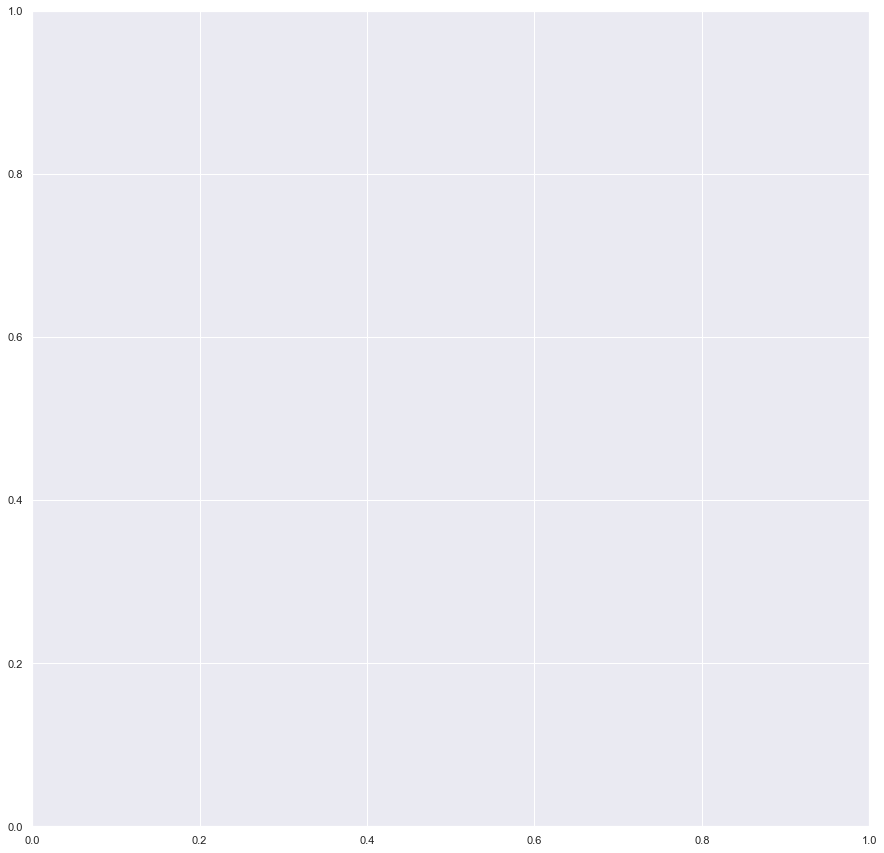

In [13]:
def do_plot_dist(classifier, bins):
    plot_dist(classifier, 'lossless', 1, bins, 'lossless')
    plot_dist(classifier, 'codec', 'mp3', bins, 'mp3')
    plot_dist(classifier, 'codec', 'vorbis', bins, 'vorbis')
    plot_dist(classifier, 'essentia_low', '2.1-beta1', bins, '2.1-beta1')
    plot_dist(classifier, 'bit_rate', 320000, bins, '320kbps')
    plot_dist(classifier, 'bit_rate', 128000, bins, '128kbps')
    plot_dist(classifier, 'bit_rate', 160000, bins, '160kbps')
    plot_dist(classifier, 'bit_rate', 192000, bins, '192kbps')
    plot_dist(classifier, 'bit_rate', 256000, bins, '256kbps')

def plot_dist(idx, col, value, bins, label):
    binned = pd.cut(acousticbrainz[idx], bins=bins, labels=False)

    val_count = {}
    total_count = {}

    for i in range(0, bins):
        val_count[i] = 0
        total_count[i] = 0

    for i in tqdm(range(0, len(binned))):
        idx = binned.index[i]
        b = binned.values[i]

        val = acousticbrainz.at[idx, col]
        if val == value:
            val_count[b] += 1
        total_count[b] += 1

    a = np.array(list(val_count.values()))
    b = np.array(list(total_count.values()))

    vals = np.nan_to_num(a/b)

    plt.plot([x/(bins-1) for x in counts.keys()], vals, label=label)

fig = plt.figure()
ax = fig.gca()

# Mood_acoustic
do_plot_dist(toSelect[1], 200)

plt.title("Fraction of entries with certain metadata for classifier values of mood_acoustic")
plt.xlabel("mood_acoustic value")
plt.ylabel("Metadata fraction")
plt.legend()
plt.show()